# 📘 How to Deflate a Brazilian Time Series Using IPCA
This tutorial presents a step-by-step guide for deflating Brazilian macroeconomic time series using official inflation data from the Central Bank of Brazil and the IPCA (Broad Consumer Price Index). In high-inflation economies like Brazil, deflating nominal figures is essential to perform accurate and consistent economic analysis over time.

## 🔧 Step 1: Import Required Packages

In [1]:
from bcb import sgs
import pandas as pd

## 📥 Step 2: Download Time Series Data
We'll use two datasets from the Central Bank of Brazil:
- IPCA (code 433): The official inflation index
- Credit to households (code 20681): As an example of a nominal series

In [2]:
# Downloading the inflation index (IPCA)
IPCA = sgs.get({'inflation': 433}, start='2000-01-01')

# Downloading a nominal macroeconomic indicator (e.g., credit card volume)
credit_card = sgs.get({'nominal_value': 20681}, start='2000-01-01')

## ⚙️ Step 3: Prepare the Inflation Index

In [3]:
# Convert from percent to decimal
IPCA['inflation'] /= 100

# Build monthly index
IPCA['index'] = IPCA['inflation'] + 1
IPCA.loc[IPCA.index == IPCA.index[0], 'index'] = 1

# Reset index to work with dates more easily
IPCA.reset_index(inplace=True)

# Create and compute cumulative inflation factor
IPCA['cumulative_index'] = 0
IPCA.loc[0, 'cumulative_index'] = 1

for i in IPCA.index[1:]:
    IPCA.at[i, 'cumulative_index'] = IPCA.loc[i, 'index'] * IPCA.loc[i - 1, 'cumulative_index']

/var/folders/wf/v9w4ylg97c3b4s8kh8y623g00000gn/T/ipykernel_89128/1675007413.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0013' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  IPCA.at[i, 'cumulative_index'] = IPCA.loc[i, 'index'] * IPCA.loc[i - 1, 'cumulative_index']


## 📉 Step 4: Compute the Deflator

In [4]:
# Define base date and compute deflator
base_date = '2025-01-01'
IPCA['deflator'] = IPCA['cumulative_index'] / IPCA[IPCA.Date == base_date]['cumulative_index'].values[0]

# Set date as index
IPCA.set_index('Date', inplace=True)

# Optional: preview recent values
IPCA[IPCA.index > '2019-01-01'].head(12)

,inflation,index,cumulative_index,deflator
Date,,,,
2019-02-01,0.0043,1.0043,3.215073,0.722589
2019-03-01,0.0075,1.0075,3.239186,0.728009
2019-04-01,0.0057,1.0057,3.257649,0.732158
2019-05-01,0.0013,1.0013,3.261884,0.733110
2019-06-01,0.0001,1.0001,3.262210,0.733183
2019-07-01,0.0019,1.0019,3.268408,0.734576
2019-08-01,0.0011,1.0011,3.272003,0.735384
2019-09-01,-0.0004,0.9996,3.270695,0.735090
2019-10-01,0.0010,1.0010,3.273965,0.735825


## 🧮 Step 5: Deflate the Nominal Series

<Axes: title={'center': 'Nominal vs Real Credit Volume'}, xlabel='Date'>

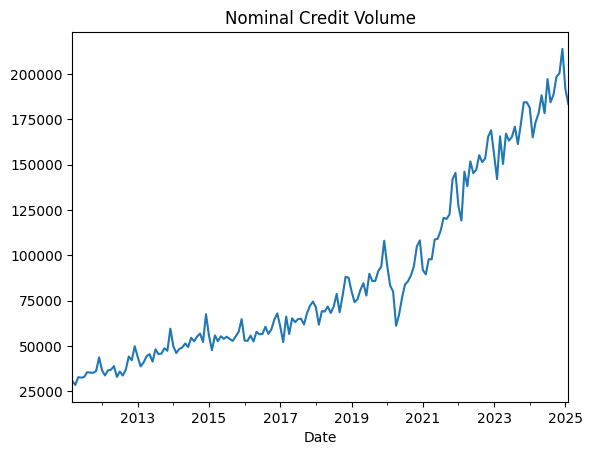

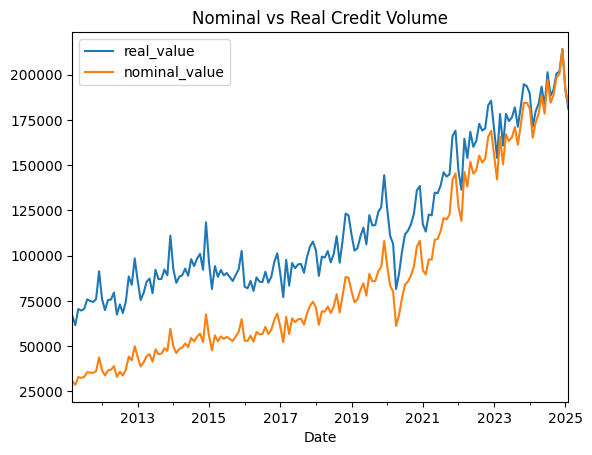

In [5]:
# Reload nominal series to ensure index match
credit_card = sgs.get({'nominal_value': 20681}, start='2000-01-01')

# Plot nominal series
credit_card['nominal_value'].plot(title='Nominal Credit Volume')

# Join with IPCA deflator
credit_card = credit_card.join(IPCA)

# Calculate real value
credit_card['real_value'] = credit_card['nominal_value'] / credit_card['deflator']

# Plot both series
credit_card[['real_value', 'nominal_value']].plot(title='Nominal vs Real Credit Volume')

## ✅ Final Result
The `real_value` column now contains a deflated version of the nominal series, allowing for meaningful historical comparisons free from inflation distortions.

In [6]:
credit_card

,nominal_value,inflation,index,cumulative_index,deflator,real_value
Date,,,,,,
2011-03-01,30674,0.0079,1.0079,2.048216,0.460338,66633.702870
2011-04-01,28554,0.0077,1.0077,2.063987,0.463882,61554.418270
2011-05-01,32854,0.0047,1.0047,2.073688,0.466062,70492.696996
2011-06-01,32505,0.0015,1.0015,2.076799,0.466762,69639.411215
2011-07-01,32992,0.0016,1.0016,2.080122,0.467508,70569.858716
...,...,...,...,...,...,...
2024-10-01,198439,0.0056,1.0056,4.402122,0.989379,200569.217354
2024-11-01,200437,0.0039,1.0039,4.419290,0.993238,201801.639236
2024-12-01,213872,0.0052,1.0052,4.442271,0.998403,214214.195200
